# -1 Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.special as sspecial
import viz.plotter as plotter
from tree import LibFmm2dNode
from particles import Particles2D

# 0 Preface

The goal of this notebook is to synthesize many hours of personal research on all the ins and outs of the Fast 
Multipole Method (FMM) in order to be prepared to implement it in the near future. I was also supposed to give a talk on this to my research group, but overslept, so its also an attempt to make up for dropped appointments. In doing this synthesis, I am trying to make something which makes sense to me, and therefore might make sense to a wider audience. The audience I have in mind writing this is someone who is moderately literate mathematically, computationally, and physically. This means you should have majored in a stem field, and have fairly good experience with a computer. Experience here means you can understand the logic and data structures used in computing; you don't have to write codes for a super computer (all though that would be useful). 

# 1 Informal Introduction

## 1.1 The Problem

Science is all about understanding interactions, but it tends to be the case that completely understanding a set of interactions becomes intractable as the number of interactions increases, which makes computers perfectly suited for the task of modelling such interactions. In a rapid transition to more formal language, here we are interested in the interactions between $N$ charged particles, but the algorithm we will learn has a much broader scope of applications.

In the simplest case, the electrostatic/gravitational $N$ body problem is defined as the dynamics of a system of $N$ particles through a force that is never 0, even to within computer precision. This means that the equations of motion for particle $i$ in 3 dimensions are

\begin{align}
\dot{\mathbf{v}}_{i} &= \sum_{j=0}^{N}\frac{1-\delta_{ij}}{m_{i}}\mathbf{F}(\mathbf{r}_{ij})\\
\dot{\mathbf{r}}_{i} &= \mathbf{v}_{i}\\
\mathbf{F}(\mathbf{r}_{ij}) &=\frac{k q_{i}q_{j}\hat{\mathbf{r}}_{ij}}{|\mathbf{r}_{ij}|^{2}}
\end{align}

where $\delta_{ij}$ is the kronecker delta and $\mathbf{r}_{il}\equiv \mathbf{r}_{i}-\mathbf{r}_{l}$. The overall number of computations needed to 'exactly' solve such a system of equations is dependent on calculating the force, which scales as $\mathcal{O}(N^{2})$ (even accounting for Newton's third law). This is prohibitively expensive as $N$ gets larger and larger, so in order to access the physics 
of larger physical systems (e.g. galaxies, cells, complex materials, fusion plasmas, etc.) in a reasonable time we need something
faster without suffering terribly with respect to accuracy. 

## 1.2 The Basic Idea

The algorithm we are trying to build up to is called the Fast Multipole Method, but the fundamental idea behind the algorithm is simple: clustering congeals local information in a way accessible to any other cluster. To help show this, let's also make a visualization.

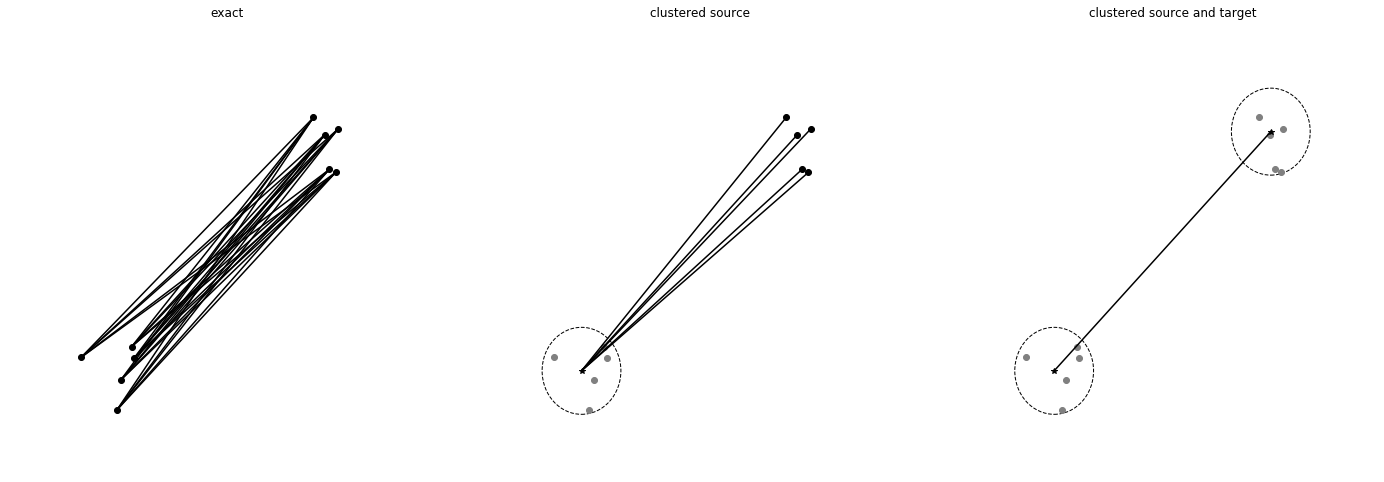

In [3]:
plotter.make_cluster_plot()

The left most plot shows every interaction between particle pairs. Its pretty dense; thats the $\mathcal{O}(N^{2})$ scaling rearing its head again. But, based off of the form of the force in our problem, it's reasonable to think that so long as distance to the source particles is _large enough_ the force anywhere inside the circle in the center plot has to be _similar_ to the force at the center of the circle. This same fact also tells us something about the source particles: in order for the force on the targets to be similar, each target particle must see roughly the same source distribution--the sources are also clustered. So instead of following $N^{2}$ pair interactions, we should be able to follow the interactions of the 2 clusters if they are far enough apart, and since cluster information is local, it can be computed in $\mathcal{O}(N)$ time. __Thats a huge change!__  However, we haven't setup any of the infrastructure needed to show how to '_cache_' in on those savings, so now we need to do some
math. 

# 2 Mathematical Preliminaries

## 2.1 Formal Problem

The basic problem outlined above can be considered a subset of problems coming from potential theory, which is basically concerned with generating the force field from a system of charges (masses in gravitational cases). As we are about to see, getting these fields is ultimately about 
getting a scalar function whose gradient is the force field. Ultimately it can be shown that these
scalar fields obey the poisson equation: 

\begin{align}
\nabla^{2}\phi &= -k\rho(\mathbf{x})
\end{align}

where $k$ is a constant and $\rho$ is a description of the distribution of field sources in the
domain.

## 2.2 Fundamental Solutions

This can be solved ('inverted') by seeking the solution for a delta function source:

\begin{align}
\nabla^{2}\phi &= -k\delta(\mathbf{x}-\mathbf{x}')
\end{align}

We can do this for any dimension, but will do it explicitly for  2, and 3 dimensions, but before doing so it is necessary to show one trait of the solution.  

### 2.2.1 Directional Invariance of the Fundamental Solution

Consider a linear coordinate transformation

\begin{align}
\mathbf{y}=A\mathbf{x} \implies y_{\alpha} = A_{\alpha\beta}x_{\beta}
\end{align}

subject to the constraint that $A$ is orthogonal:
\begin{align}
AA^{T} = A^{T}A = I \implies A_{\alpha\beta}A_{\gamma\beta}=A_{\beta\alpha}A_{\beta\gamma}=\delta_{\alpha\gamma}
\end{align}

And consider the two functions $\phi(x_{i})$ and $\psi(y_{i}) = \phi(A_{\alpha\beta}x_{\beta})$. First
we have
\begin{align}
\frac{\partial \phi}{\partial x_{i}} = \frac{\partial \psi}{\partial y_{j}}A_{ji}
\end{align}

Which means the laplacian is
\begin{align}
\nabla^{2}\phi &= \frac{\partial}{\partial x_{\gamma}}\left(\frac{\partial \phi}{\partial x_{\nu}}\right)\delta_{\gamma\nu}\\
&= \delta_{\gamma\nu}A_{\beta\gamma}\frac{\partial}{\partial y_{\beta}}\left(
A_{\alpha\nu}\frac{\partial \psi}{\partial y_{\alpha}}\right)\\
&= \delta_{\gamma\nu}A_{\beta\gamma}A_{\alpha\nu}\frac{\partial^{2}\phi}{\partial y_{\beta}\partial y_{\alpha}}\\
&= A_{\beta\gamma}A_{\alpha\gamma}\frac{\partial^{2}\psi}{\partial y_{\beta}\partial y_{\alpha}}\\
&= \delta_{\alpha\beta}\frac{\partial^{2}\psi}{\partial y_{\beta}\partial y_{\alpha}}\\
&= \frac{\partial^{2}\psi}{\partial y_{\alpha}^{2}}\\
&= \nabla^{2}\psi
\end{align}

Thus changing the direction which points to the delta source has no impact on the solution, meaning that the solution can only depend on the _distance_ to the delta source function. So our solution should instead be written as a function of 
\begin{align}
r = \sqrt{(x_{i}-x_{i}')^{2}} = |\mathbf{x}-\mathbf{x}'|
\end{align}

Note that this means the laplacian in $n$ dimensions now becomes

\begin{align}
\nabla^{2}\phi &= \phi''(r) + \frac{n-1}{r}\phi'(r)
\end{align}

### 2.2.2 Solutions

The radially symmetric fundamental solutions to the poisson equation can now be found; although in a non-obvious way. Start by solving the homogeneous poisson equation:

\begin{align}
\phi''(r) + \frac{n-1}{r}\phi'(r) = 0
\end{align}
 
which has solutions
 
\begin{align}
\phi_{2D}(r) &= C_{1}\log(r) + C_{2}\\
\phi_{3D}(r) &= \frac{C_{1}}{r} + C_{2}
\end{align}

We can then force these to match the delta function source term by using Gauss's law:

\begin{align}
\int \nabla\phi(r)\cdot\mathbf{n}d\Omega &= -k \int \delta(\mathbf{x}-\mathbf{x}')d^{3}x
\end{align}

to get the fundamental solutions

\begin{align}
\Phi_{2D}(|\mathbf{x}-\mathbf{x}'|) &= -\frac{k}{2\pi}\log(|\mathbf{x}-\mathbf{x}'|)\\
\Phi_{3D}(|\mathbf{x}-\mathbf{x}'|) &= \frac{k}{4\pi|\mathbf{x}-\mathbf{x}'|}
\end{align}

Taking the negative gradient of the solution for 3D should convince you that solving for $\Phi$ and
the force are one and the same (save a gradient). 

### 2.2.3 What Have We Accomplished?

Techinically, we have the solution to our problem; given any $\rho(\mathbf{x}')$, and the condition that at infinity the potential is 0, we can express the potential as 

\begin{align}
\phi(\mathbf{x}) = \int\Phi(|\mathbf{x}-\mathbf{x}'|)\rho(\mathbf{x}')d^{3}\mathbf{x}'
\end{align}

however it hasn't accomplished what we need to escape the $\mathcal{O}(N^{2})$ scaling since both solutions depend on pairwise differences. What we _want_ is a fundamental solution that can be expressed in the form
\begin{align}
\phi(\mathbf{x}) = \int f(\mathbf{x})g(\mathbf{x}')\rho(\mathbf{x}')d^{3}\mathbf{x}'
\end{align}

Accomplishing that is a vital part of the FMM algorithm, but also very distinct depending on if the problem is in 2D
or 3D. For this reason, the rest of this overview will be divided into a part for 2D and a part for 3D. 

# 3 Factorizing Potentials in 2D

## 3.1 Intro

We have already shown that the solution to the potential problem

\begin{align}
\nabla^{2} \Phi_{2D} = -k\delta(\mathbf{x}-\mathbf{x}')
\end{align}

is given by

\begin{align}
\Phi_{2D}(|\mathbf{x}-\mathbf{x}'|) = -\frac{k}{2\pi}\log(|\mathbf{x}-\mathbf{x'}|)
\end{align}

so that for a general function $\rho(\mathbf{x}')$ the solution is given by

\begin{align}
\phi(\mathbf{x}) = \int \Phi_{2D}(|\mathbf{x}-\mathbf{x}'|)\rho(\mathbf{x}')d^{2}\mathbf{x}'
\end{align}

but this does not give an increase in computational efficiency since the pairwise evaluation of $\Phi_{2D}$ is still
$\mathcal{O}(N^{2})$. In this chapter we will generate a form of $\Phi_{2D}$ that factorizes into a form

\begin{align}
\Phi_{2D}(|\mathbf{x}-\mathbf{x}'|) = f(\mathbf{x})g(\mathbf{x}')
\end{align}

under certain conditions. Based on that factorization, we will define 2 different mathematical objects and 3
operators on those objects that are the mathematical basis of FMM. 

## 3.2 Factorization: The Long Range Expansion (2D)

### 3.2.1 Derivation

Consider two randomly located unit charges in the real plane, located at $\mathbf{r}$ and $\mathbf{r}'$ with respect to the origin $O$ such that $|\mathbf{r}|>|\mathbf{r}'|$:

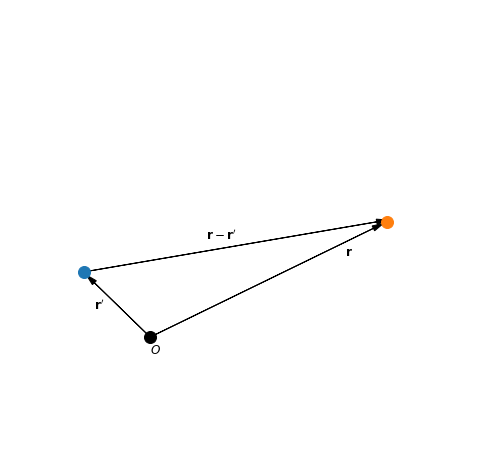

In [4]:
plotter.make_2body_plot()

Using standard vector notation each of the three vectors above are

\begin{align}
\mathbf{r} &= x\hat{\mathbf{e}}_{0} + y\hat{\mathbf{e}}_{1}\\
\mathbf{r}' &= x'\hat{\mathbf{e}}_{0} + y'\hat{\mathbf{e}}_{1}\\
\end{align}

And the potential at $\mathbf{r}$ due to the charge at $\mathbf{r}'$ is 

\begin{align}
\Phi_{2D}(|\mathbf{r}-\mathbf{r}'|) &= -\frac{k}{2\pi}\log(|\mathbf{r}-\mathbf{r}'|)\\
\end{align}

Now, because mathematicians are silly in the most reasonable way, the same potential would result if 
we instead defined the two _complex_ numbers
\begin{align}
\mathcal{z} &= x + iy = re^{i\alpha}\\
\mathcal{z}' &= x' + iy' = r'e^{i\beta}\\
\end{align}

for the inputs to a complex potential

\begin{align}
\tilde{\Phi}_{2D}(|\mathcal{z}-\mathcal{z}'|) &= -\frac{k}{2\pi}\log(|\mathcal{z}-\mathcal{z}'|)\\
\end{align}

The actual physical potential is the real component of this complex potential:
\begin{align}
\Phi_{2D}(|\mathbf{r}-\mathbf{r}'|) = \mathfrak{Re}\left[\tilde{\Phi}_{2D}(|\mathcal{z}-\mathcal{z}'|)\right]
\end{align}

  
  __How does this help us any in factorization?__ Well, remember from precalculus that
\begin{align}
|\mathcal{z}-\mathcal{z}'| &=\sqrt{(\mathcal{z}-\mathcal{z'})
(\mathcal{z}^{*}-\mathcal{z}'^{*})}\\
&= |\mathcal{z}||1-\frac{\mathcal{z'}}{\mathcal{z}}|
\end{align}

Allowing the complex potential to be re-written as

\begin{align}
\tilde{\Phi}_{2D}(z) &= -\frac{k}{2\pi}\log(|z|) - \frac{k}{2\pi}\log\left(|1-\frac{\mathcal{z'}}{\mathcal{z}}|\right)
\end{align}

Now by the requirements on $\mathbf{r}$ and $\mathbf{r}'$, we can define a small parameter $\epsilon<1$:
\begin{align}
\frac{\mathcal{z}'}{\mathcal{z}} \equiv \frac{r'}{r}e^{i(\beta-\alpha)} \equiv \epsilon e^{i(\beta-\alpha)}
\end{align}
so that
\begin{align}
\log\left(|1-\frac{\mathcal{z'}}{\mathcal{z}}|\right) &=
\log\left(\sqrt{1-2\epsilon\cos(\beta-\alpha)+\epsilon^{2}}\right)
\end{align}

While it will certainly build character and hone your arithemtic abilities, I will spare you the formal expansion of this and tell you that expanding about $\epsilon=0$ will give you

\begin{align}
\log\left(\sqrt{1-2\epsilon\cos(\beta-\alpha)+\epsilon^{2}}\right) &=
(-1)\sum_{n=1}^{\infty}\frac{\epsilon^{n}\cos[ n(\beta-\alpha)]}{n}\\
&= \mathfrak{Re}\left[(-1)\sum_{n=1}^{\infty}\frac{\mathcal{z}'^{n}}{n\mathcal{z}^{n}}\right]
\end{align}

So that the factored form of the potential is

\begin{align}
\tilde{\Phi}_{2D}(\mathcal{z}, \mathcal{z}') &= -\frac{k}{2\pi}\log(\mathcal{z}) + \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\mathcal{z}'^{n}}{n\mathcal{z}^{n}}\\
\Phi_{2D}(\mathbf{x},\mathbf{x}') &= \mathfrak{Re}\left[\tilde{\phi}(\mathcal{z},\mathcal{z}')\right]
\end{align}

### 3.2.2 Error Examination Via Pretty Vizualization

Obviously no computer can compute the infinite number of terms in the above factorization, but due to the very
nature of computers, even if they could that wouldn't be useful. The limited precision of computational arithmetic
means that for a given $z$ and $z'$, the factorized expansion and exact potential become numerically identical. Still,
it is prudent to examine how far off our factorization is for a given number of terms. To start, we can visualize
the error for all $z>z'$ for fixed $p$.

In [5]:
rprime = 0.25
beta = np.pi

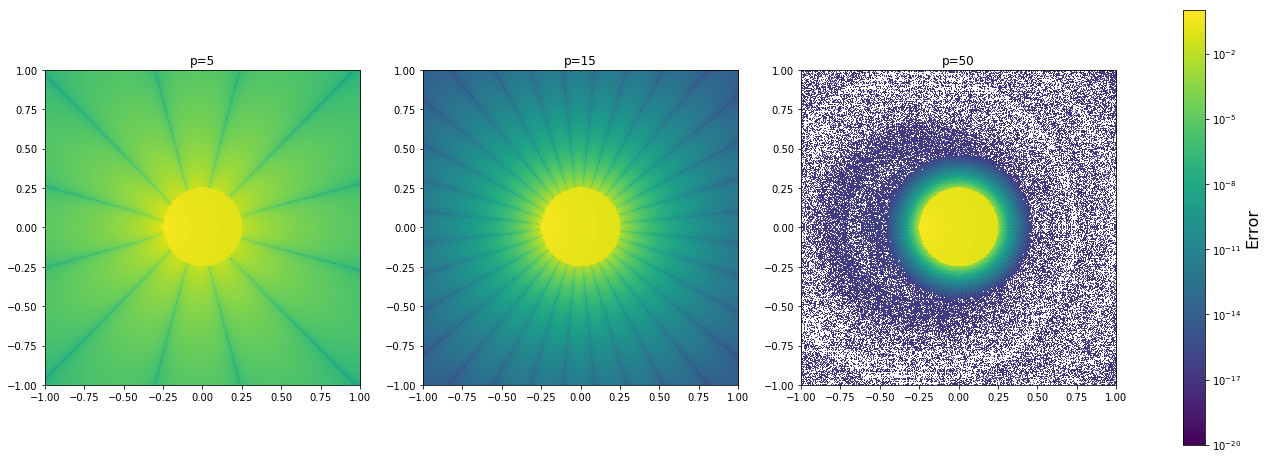

In [6]:
def get_appx_pot(z, zp, lim):
    eps = zp/z
    m = np.absolute(eps) < 1
    out = np.zeros(z.shape, dtype=np.complex128)
    out[m] = -np.log(z[m])
    for n in range(1, lim+1):
        out[m] += np.power(eps[m], n)/n
    out = 0.5*out/np.pi
    return np.real(out)


def get_pot(x, y, rprime, beta):
    xp = rprime*np.cos(beta)
    yp = rprime*np.sin(beta)
    out = ((x-xp)**2) + ((y-yp)**2)
    out = np.sqrt(out)
    out = -0.5*np.log(out)/np.pi
    return out


def get_err(pot, apot):
    return np.abs(pot - apot)

plotter.make_2d_mpole_err_plot(rprime, beta, get_appx_pot, get_pot, get_err)

## 3.3 FMM Objects and Operators (2D)

Our new found factorization seems promising; given two charges that are far apart relative to 
their distance to the origin we have a factorization of their potential energy. That still doesn't 
get us over the $\mathcal{O}(N^{2})$ hump though. To accomplish that we need to find expressions for
the potential to _clusters_ of charges, and luckily for us, the factorization makes that possible!

### 3.3.1 FMM Objects (2D)

#### 3.3.1.1 Multipoles (2D)

Given a set of $n_{1}$ charges of strengths $Q =  \{q_{i}, i=1,...,N\}$ located at points $A = \{z'_{i}, i=1,...,n\}$ 
__inside__ a circle $S$ of radius $\rho_{max}$ about the origin  in $\mathbb{C}$, the complex potential at
any point $\mathcal{z}$ such that $|\mathcal{z}|>\rho_{max}$ is given by
\begin{align}
\tilde{\phi}(\mathcal{z}) = -\frac{k\omega_{0}(Q)}{2\pi}\log(\mathcal{z}) + \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{n}(Q, A)}{\mathcal{z}^{n}}
\end{align}
where the _multipole_ of order $0$ about the origin is defined as
\begin{align}
\omega_{0}(Q) \equiv \sum_{i=1}^{n}q_{i}
\end{align}
and the multipole of order $n$ about the origin is defined as
\begin{align}
\omega_{n}(Q, A) \equiv \sum_{i=1}^{n}q_{i}O_{n}(z'_{i})
\end{align}
where the chargless pole moment of order $n$ is
\begin{align}
O_{n}(z) = \frac{\mathcal{z}^{n}}{n} 
\end{align}

It should be pretty clear where we got these multipoles from: we simply isolated the $z'$ terms in our factorization,
gave them labels depending on their order, and summed them all together.

#### 3.3.1.2 Local Expansions (2D)

Given a set of $n_{2}$ charges of strengths $Q'=\{q_{j}, j=1,...,n_{2}\}$ located at points 
$B=\{\mathcal{z}_{j}, j=1,...,N'\}$ __outside__ a circle $S$ of
radius $\rho_{max}$ about the origin in $\mathbb{C}$, the complex potential at any point $\mathcal{z}'$ such that $|\mathcal{z}'|<\rho_{max}$
is given by 

\begin{align}
\tilde{\phi}(\mathcal{z}') = \frac{k}{2\pi}\sum_{n=1}^{\infty}\mu_{n}z'^{n}
\end{align}

where the _local expansion_ about the origin of order $n$ is defined as 

\begin{align}
\mu_{n}(Q', B) = \sum_{j=1}^{N'}q_{j}M_{n}(z_{j})
\end{align}

where the chargless local expansion of order $n$ is

\begin{align}
M_{n}(z_{j}) = \frac{1}{n z_{j}^{n}}
\end{align}

Again, it is pretty obvious where we got this from. We took the factorized form of $\tilde{\Phi}_{2D}$ and removed all
of the terms that did not depend on the location of charges about the origin. Then we 
just gathered and summed all of the external terms. 

### 3.3.2 FMM Operators (2D)

#### 3.3.2.1 A Performance Analysis Interlude

At this point we can envisage a fairly simple algorithm, and it its performance will be useful in motivating several 
operators that will be defined momentarily. Imagine the most basic molecular dynamics simulation possible: $N$ charged
particles uniformly distributed over a 2D box with sides of length $L$. We can easily imagine a very basic algorithm:

In [ ]:
interior_part_rs = []
exterior_part_rs = []


for i in range(len(part_rs)):
    if part_locations[i] < r:
        interior_part_rs.append(part_locs[i])
    else:
        exterior_part_rs.append(part_locs[i])
        
n1 = len(interior_part_rs)
n2 = len(exterior_part_rs) #should == N-n1

int_pots = np.zeros(n1)
ext_pots = np.zeros(n2)

ext_multipoles = np.zeros(p)
int_exps = np.zeros(p)


for i in range(p):
    for j in range(n1):
        #get the multipole of each interior particle
    


for i in range(p):
    for j in range(n2):
        #get the local expansion of each exterior particle:
        
        
for i in range(p):
    for j in range(n1):
        #evaluate interior expansion for each interior particle
        
        
for i in range(n1):
    for j in range(i+1, n1):
        #get interactions between all interior particles
        

for i in range(n2):
    for j in range(i+1, n2):
        #get interactions between all exterior particles 


Clearly this scales as 
\begin{align}
\mathcal{O}(2pn_{1} + 2pn_{2} + n_{1}^{2} + n_{2}^{2})
\end{align}
This isn't great. We still get $\mathcal{O}(N^{2})$ scaling here because $n_{1}$ and $n_{2}$ will both be $~N/2$. What
we need is a way to form clusters out of clusters, local expansions from multipoles, and local expansions about
different origins. 

#### 3.3.2.2 Multipole to Multipole (M2M, 2D)

Consider a cluster of charges contained in a circle of radius $\rho$ about the point $\mathbf{O}'$, located a distance
$\mathbf{r}_{0}$ away from the origin $\mathbf{O}$. What is the multipole expansion of this cluster of charges at
the point $\mathbf{r}$?

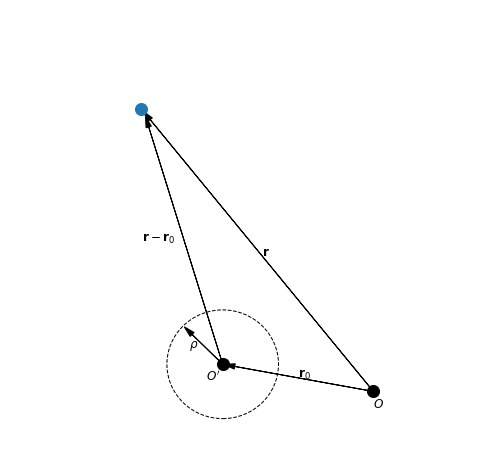

In [7]:
plotter.make_m2m_plot()

Well, if we assume $|\mathbf{r}-\mathbf{r}_{0}|>\rho$, then we know the complex expansion is of the form

\begin{align}
\tilde{\phi}(\mathcal{z}-\mathcal{z}_{0}) =  -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z}-\mathcal{z}_{0}) 
+ \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{n}}{(\mathcal{z}-\mathcal{z}_{0})^{n}}
\end{align}

Now if we also assume $|\mathbf{r}|>|\mathbf{r}_{0}|$, then $|\mathcal{z}|>|\mathcal{z}_{0}|$ and we can use this
to expand the complex potential:
\begin{align}
\tilde{\phi}(\mathcal{z}, \mathcal{z}_{0}) =  -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z}) 
-\frac{k\omega_{0}}{2\pi}\log(1-\frac{\mathcal{z}_{0}}{\mathcal{z}})
+ \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{n}}{z^{n}(1-\mathcal{z}_{0}/\mathcal{z})^{n}}
\end{align}
From the derivation of the long range expansion we can rewrite the second log term:
\begin{align}
\tilde{\phi}(\mathcal{z}, \mathcal{z}_{0}) =  -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z}) 
+\frac{k \omega_{0}}{2\pi}\sum_{n=1}^{\infty}\frac{\mathcal{z}_{0}^{n}}{n\mathcal{z}^{n}}
+ \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{n}}{z^{n}(1-\mathcal{z}_{0}/\mathcal{z})^{n}}
\end{align}


Now, again define a small parameter $\varepsilon$:
\begin{align}
\frac{\mathcal{z}_{0}}{\mathcal{z}} \equiv \frac{r_{0}}{r}e^{i(\delta-\alpha)} = \varepsilon e^{i(\delta-\alpha)}
\end{align}
We can expand
\begin{align}
f(\varepsilon, n) = (1-\varepsilon e^{i(\delta-\alpha)})^{-n}
\end{align}
Given the derivatives,
\begin{align}
f'(\varepsilon, n) &= n e^{i(\delta-\alpha)}f(\varepsilon, n+1)\\
f^{s}(\varepsilon, n) &= \frac{(n+s-1)!}{(n-1)!}e^{is(\delta-\alpha)}f(\varepsilon, n+s)
\end{align}
we can expand about $\varepsilon=0$ to get
\begin{align}
f(\varepsilon, n) &= \sum_{s=0}^{\infty}\frac{(n+s-1)!}{(n-1)!s!}\frac{z_{0}^{s}}{z^{s}}
\end{align}
Then plugging this in to the potential expansion gives
\begin{align}
\tilde{\phi}(\mathcal{z},\mathcal{z}_{0}) = -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z})
+\frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{0}\mathcal{z}_{0}^{n}}{nz^{n}}
+\frac{k}{2\pi}\sum_{n=1}^{\infty}\sum_{s=0}^{\infty}\frac{(n+s-1)!}{(n-1)!s!}\frac{\omega_{n}\mathcal{z}_{0}^{s}}
{\mathcal{z}^{n+s}}
\end{align}

Now, define two new summation indices:
\begin{align}
l &= n+s\\
m &= n
\end{align}

\begin{align}
\tilde{\phi}(\mathcal{z},\mathcal{z}_{0}) &= -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z})
+\frac{k}{2\pi}\sum_{l=1}^{\infty}\frac{\omega_{0}\mathcal{z}_{0}^{l}}{lz^{l}}
+\frac{k}{2\pi}\sum_{l=1}^{\infty}\sum_{m=1}^{l}\frac{(l-1)!}{(m-1)!(l-m)!}\frac{\omega_{m}\mathcal{z}_{0}^{l-m}}
{\mathcal{z}^{l}}\\
\end{align}
So that the potential at $z$ is
\begin{align}
\tilde{\phi}(\mathcal{z}) &= -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z})
+ \frac{k}{2\pi}\sum_{l=1}^{\infty}\frac{\bar{\omega}_{l}}{\mathcal{z}^{l}}
\end{align}
Where the shifted multipoles are given by
\begin{align}
\bar{\omega}_{l} = \frac{\omega_{0}\mathcal{z}_{0}^{l}}{l} + \sum_{m=1}^{l}\frac{(l-1)!}{(m-1)!(l-m)!}\omega_{m}\mathcal{z}_{0}^{l-m}
\end{align}
Thus given the multipole expansion about about a shifted origin we can express it as a multipole about another
origin for points sufficiently far away from both origins!

#### 3.3.2.2 Multipole to Local (M2L, 2D)

We now have a way to find the total potential of multiple clusters about a common origin at a point, however to evaluate that potential for a group of charges well separated from that point we would need to do the M2M operation
for each charge in that group. Rather than have to do such an operation multiple times, we can find a single potential
at the center of the group and then expand that to each point. 

To make this clearer, consider a cluster of charges inside a circle, $C_{1}$, of radius $\rho_{max}$ 
at $\mathbf{r}_{0}$ and another cluster of charges inside another circle, $C_{0}$, of radius $\rho_{max}$ 
at the origin.

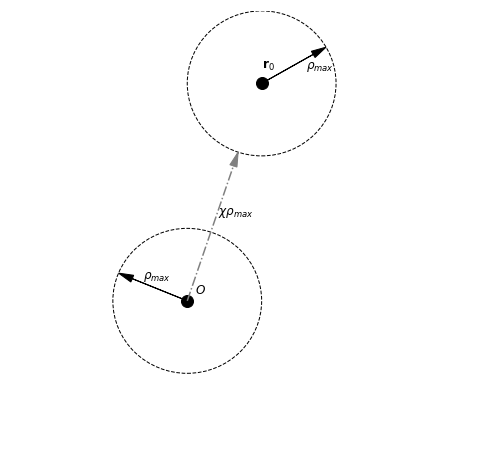

In [8]:
plotter.make_m2l_plot()

If $\chi>1$, then we know the potential at any point inside $C_{0}$ can be
given by the multipole expansion:
\begin{align}
\tilde{\phi}(\mathcal{z}-\mathcal{z}_{0}) =  -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z}-\mathcal{z}_{0}) 
+ \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{n}}{(\mathcal{z}-\mathcal{z}_{0})^{n}}
\end{align}
where $\mathcal{z}$ is the location of the point relative to the origin $\mathbf{O}$. Also note that for any $z$ in
$C_{0}$ that $\mathcal{z} < \mathcal{z}_{0}$. Therefore we can approximate the value at any such point by taylor expanding around the value _at_ the origin. This can be done fairly easily using the expansion from the
previous section:

\begin{align}
\tilde{\phi}(\mathcal{z}-\mathcal{z}_{0}) &=  -\frac{k\omega_{0}}{2\pi}\log(\mathcal{z}-\mathcal{z}_{0}) 
+ \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{n}}{(\mathcal{z}-\mathcal{z}_{0})^{n}}\\
&= -\frac{k\omega_{0}}{2\pi}\log(-\mathcal{z}_{0})
-\frac{k\omega_{0}}{2\pi}\log(1-\frac{\mathcal{z}}{\mathcal{z}_{0}})
+ \frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{(-1)^{n}\omega_{n}}{\mathcal{z}_{0}^{n}(1-\mathcal{z}/\mathcal{z}_{0})^{n}}\\
&= -\frac{k\omega_{0}}{2\pi}\log(-\mathcal{z}_{0})
+\frac{k}{2\pi}\sum_{n=1}^{\infty}\frac{\omega_{0}\mathcal{z}^{n}}{n\mathcal{z}_{0}^{n}}
+\frac{k}{2\pi}\sum_{n=1}^{\infty}\sum_{l=0}^{\infty}\frac{(-1)^{l}\omega_{n}(n+l-1)!\mathcal{z}^{l}}
{(n-1)!l!\mathcal{z}_{0}^{l+n}}
\end{align}

We can rewrite this as a local expansion:
\begin{align}
\tilde{\phi}(\mathcal{z}) &= \frac{k}{2\pi}\sum_{l=0}^{\infty}\mu_{l}\mathcal{z}^{l}\\
\mu_{0} &= -\omega_{0}\log(-\mathcal{z}_{0}) + \sum_{n=1}^{\infty}\frac{\omega_{n}}{\mathcal{z}_{0}^{n}}\\
\mu_{l} &= \frac{1}{\mathcal{z}_{0}^{l}}\sum_{n=1}^{\infty}\frac{(-1)^{n}\omega_{n}(n+l-1)!}
{(n-1)!l!\mathcal{z}_{0}^{n}}
\end{align}

This gives us a way to get the potential of a cluster by evaluating the multipole moments of all external charges only once. 

#### 3.3.2.3 Local to Local (L2L, 2D)

The last operation we need before stating the base FMM algorithm is fairly simple. Above we showed how to get the value
of the field at any interior point of a cluster about the origin. However, there could be an additional cluster inside
the original one that is centered at $z_{0}$. For points located at $z$ relative to this new origin such that
$|\mathcal{z}|<|\mathcal{z}_{0}|$, the local 
expansion takes the form

\begin{align}
\tilde{\phi}(\mathcal{z}) &= \frac{k}{2\pi}\sum_{l=0}^{n}\mu_{l}(\mathcal{z}-\mathcal{z}_{0})^{l}\\
\end{align}
We can again factor the polynomial into a form dependent only on $\mathcal{z}$:
\begin{align}
f(\mathcal{z},l) = (\mathcal{z}-\mathcal{z}_{0})^{l} = \sum_{m=0}^{l}\frac{l!}{m!(l-m)!}(-\mathcal{z}_{0})^{l-m}\mathcal{z}^{m}
\end{align}
\begin{align}
\tilde{\phi}(\mathcal{z}) &= \frac{k}{2\pi}\sum_{l=0}^{n}\mu_{l}(\mathcal{z}-\mathcal{z}_{0}^{l})\\
&= \frac{k}{2\pi}\sum_{l=0}^{n}\sum_{m=0}^{l}\mu_{l}\frac{l!}{m!(l-m)!}(-\mathcal{z}_{0})^{l-m}\mathcal{z}^{m}\\
&= \frac{k}{2\pi}\sum_{l=0}^{n}\sum_{m=l}^{n}\mu_{m}\frac{m!}{l!(m-l)!}(-\mathcal{z}_{0})^{m-l}\mathcal{z}^{l}\\
&= \frac{k}{2\pi}\sum_{l=1}^{n}\bar{\mu}_{l}\mathcal{z}^{l}
\end{align}
Where the shifted local multipole expansion coefficients are given by
\begin{align}
\bar{\mu}_{l} &= \sum_{m=l}^{n}\mu_{m}\frac{m!}{l!(m-l)!}(-\mathcal{z}_{0})^{m-l}
\end{align}

# 4 FMM And Variants of FMM (2D)

Now that we have a way to conglomerate clusters of charges (M2M operator), and a way to deconstruct the effect of 
external clusters into the effects on all sub clusters of a group (M2L, L2L), we can state the FMM Algorithm. After that, variants of the aglorithm will be examined that are adaptive, periodic, and include magnetism. 

## 4.1 Basic FMM 

### 4.1.0 Problem Inputs

For the FMM computation, a few inputs are needed. To start assume we have a random set of $N/2$ electron-proton
pairs in a box:

In [3]:
#the actual sim box:
bbox = np.array([[0.0, 0.0], [35, 35]])
#where we want particles setup
pbbox = np.array([[10.0, 10.0], [25, 25]])
dt = 0.1

Ntot = 1000
#charges/masses of type 0 and type 1
charges = [1, -1]
masses = [1836, 1]
ids = np.arange(Ntot)
types = np.ones(Ntot, dtype='int')
types[int(Ntot/2):] = 0

#generate positions in the box
rs = np.random.rand(Ntot, 2)
for i in range(2):
    rs[:, i] = (pbbox[1, i] - pbbox[0, i])*rs[:, i] + pbbox[0, i]

#kinetic energies corresponding to ~13.5 ev.
vs = np.zeros((Ntot, 2))
for i in range(2):
    vs[:int(Ntot/2), i] = np.random.randn(int(Ntot/2))*np.sqrt(0.5/masses[0])
    vs[int(Ntot/2):, i] = np.random.randn(int(Ntot/2))*np.sqrt(0.5/masses[1])
    
    
all_particles = Particles2D.from_vecs(bbox, charges, masses, ids, types, rs, vs, dt)

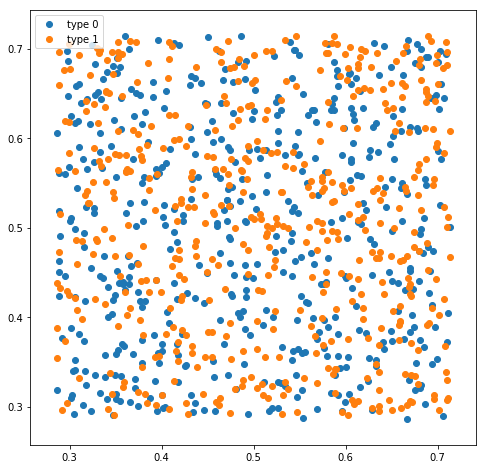

In [4]:
plotter.particle_plot2d(all_particles.parray, 2)

The FMM also requires three input parameters:
1. The number of terms to keep in the multipole sum, $p$
2. How deep clusters can be nested, $n$
3. The distance between clusters (in units of boxes) in order for the multipole expansion to converge (well separated), $c$ 

In [5]:
p = 15
n = 7
c = 1

### 4.1.1 Step 1: Partitioning and First Multipoles

First partition the total simulation domain into the quad tree with $n$ levels, and only keep nodes
with particles in them. Then find the multipole expansions of the deepest nodes:

In [6]:
def get_leaf_mpole2d(c, charges, parray, l):
    out = 0
    if l == 0:
        for i in range(parray.shape[0]):
            out += charges[parray['types'][i]]
    else:
        c = c[0] + 1j*c[1]
        for i in range(parray.shape[0]):
            omega_n = parray['x'][i] + 1j*parray['y'][i]
            omega_n = (omega_n - c)**l
            omega_n = omega_n*charges[parray['types'][i]]/l
            out += omega_n
    return out


def set_leaf_mpoles2d(td, charges):
    max_d = len(td.keys()) - 1
    for k in td[max_d].keys():
        for l in range(td[max_d][k].mpoles.shape[0]):
            td[max_d][k].mpoles[l] = get_leaf_mpole2d(td[max_d][k].center, charges, td[max_d][k].parray, l)
        

In [14]:
#holds all nodes at each level
tree_dict = {}
for l in range(n):
    tree_dict[l] = {}
    
#liberal in sense that every node stores its center, children, parents, and neighbors.
root = LibFmm2dNode(tree_dict, all_particles.parray, n, p)
set_leaf_mpoles2d(tree_dict, all_particles.charges)

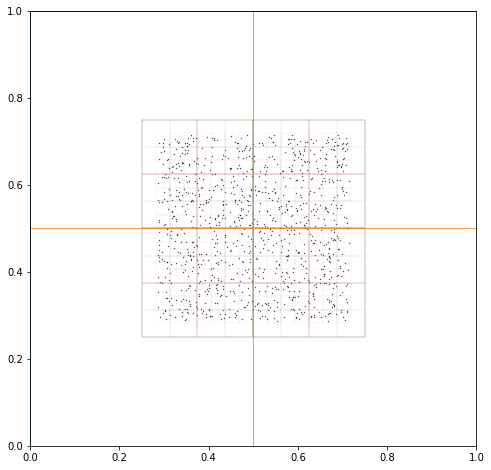

In [8]:
plotter.quadtree_plot(tree_dict)

### 4.1.2 Step 2: "Upward Pass"

Now that the smallest clusters have multipole moments, we can use the M2M operation to aggregate the groups of clusters in the same node
into a single multipole moment. 

In [15]:
#get lists of coefficients and powers
def get_m2m_lists(mnum):
    coeffs_list = []
    pows_list = []
    for lval in range(mnum):
        if lval == 0:
            coeffs = np.array([1])
            pows = np.array([0])
            coeffs_list.append(coeffs)
            pows_list.append(pows)
        else:
            ls = np.full((lval+1,), lval, dtype=np.float64)
            ms = np.arange(lval+1) 
            coeffs = sspecial.binom(ls-1, ms-1)
            coeffs[0] = 1.0/lval
            coeffs_list.append(coeffs)
            pows = ls - ms
            pows_list.append(pows)
    return coeffs_list, pows_list


def get_m2m(node, z0, l, lcoeffs, lpows):
    out = np.sum(lcoeffs*node.mpoles[:l+1]*(z0**lpows))
    return out
        
    
def upward_pass(td):
    cl, pl = get_m2m_lists(td[0][0].mpoles.shape[0])
    lev_list = list(td.keys())
    lev_list.reverse()
    #won't pass up for level 0
    lev_list = lev_list[:-1]
    for l in lev_list:
        for k in td[l].keys():
            par = td[l][k].parent
            z0 = td[l][k].center[0] - td[l-1][par].center[0]
            z0 = z0 + 1j*(td[l][k].center[1] - td[l-1][par].center[1])
            for p in range(len(cl)):
                td[l-1][par].mpoles[p] += get_m2m(td[l][k], z0, p, cl[p], pl[p])

In [16]:
upward_pass(tree_dict)

### 4.1.3 Step 3: "Downward Pass"

For every box at each level, all boxes that are $c$ boxes away from that box contribute to the local expansion of that
box. Using the L2L operation, this can then be transferred to each child box. 

In [ ]:
def downward_pass(td):
    for l in td.keys():
        

In [44]:
from bitarray import bitarray

In [35]:
v = ''
for i in tree_dict[2][3].neighs[0]:
    v += str(i)
print(int(v, 2))

0


In [58]:
sys.getsizeof('101')

52

# Appendices

# Bibliography/Reference Resources

Greengard and Rokhlin - 1987 - A fast algorithm for particle simulations

Carrier et al. - 1988 - A Fast Adaptive Multipole Algorithm for Particles

Kurzak and Pettitt - 2006 - Fast multipole methods for particle dynamics

Kabadshow - Periodic Boundary Conditions and the Error-Control (Found littered with little errors, but overall useful)

Lashuk et al. - A massively parallel adaptive fast-multipole method

Jackson - 1998 - Classical Electrodynamics 3rd Ed

Griffiths - 2013 - Introduction to Electrodynamics

Wikipedia